In [4]:
import os

gpus = [3]
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [5]:
#from tensorflow.python.keras import backend
#from tensorflow.keras import backend
import tensorflow.keras as keras

import numpy as np 
from oe_acute import MNE
import pickle
import sys
import random
#from AE import MDSAE as ae
from network_visualisation import plot_these_aud_weights
import network_visualisation
import quantify_aud_strfs
import matplotlib.pyplot as plt

In [6]:
bird = 'B1240'
d = 1024

In [7]:
segs_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/segs_list_32.pkl'.format(bird, bird)     ###change
next_path = '/mnt/cube/srrudrar/stim_preprocess/temporal_model/{}/next_list_32.pkl'.format(bird, bird)            ###change

In [8]:
def extract_spec_data(x_path, y_path, random_seed=None, global_normalize=False):

    all_curr=np.load(x_path,allow_pickle=True)
    all_next=np.load(y_path,allow_pickle=True)

    x_array = all_curr
    y_array = all_next

    if random_seed is None:
        rand_idx=np.arange(0, np.shape(x_array)[0])
    else:
        np.random.seed(random_seed)
        rand_idx=np.random.choice(range(np.shape(x_array)[0]), size=np.shape(x_array)[0],replace=False)
    
    split_train_idx, split_val_idx = rand_idx[np.shape(x_array)[0]//10:],rand_idx[:np.shape(x_array)[0]//10] 
    x_train, x_val=np.asarray(x_array)[split_train_idx], np.asarray(x_array)[split_val_idx]
    y_train, y_val=np.asarray(y_array)[split_train_idx],np.asarray(y_array)[split_val_idx]
    
    #if global_normalize:
    #    x_train=x_train/x_train.max()
    #    y_train=y_train/y_train.max()
    #    x_val=x_val/x_val.max()
    #    y_val=y_val/y_val.max()
    return x_train,y_train,x_val,y_val

In [9]:
x_train1,y_train1,x_val1,y_val1 = extract_spec_data(segs_path, next_path, random_seed=0,global_normalize=True)

In [10]:
x_train0 = x_train1[:, :32, :]
x_val0 = x_val1[:, :32, :]
y_train0 = y_train1[:, :32]
y_val0 = y_val1[:, :32]

In [11]:
x_train = np.asarray([s.flatten() for s in x_train0])
x_val = np.asarray([s.flatten() for s in x_val0])

In [12]:
np.shape(x_train), np.shape(x_val)

((51357, 1024), (5706, 1024))

In [13]:
input_img = keras.Input(shape=(1024,))
encoded = keras.layers.Dense(d, activation='relu')(input_img)
decoded = keras.layers.Dense(1024, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [14]:
encoder = keras.Model(input_img, encoded)

In [15]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(d,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [16]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [17]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_val, x_val))

Epoch 1/50
201/201 [==============================] - 4s 13ms/step - loss: 0.4072 - val_loss: 0.2728
Epoch 2/50
201/201 [==============================] - 1s 7ms/step - loss: 0.2662 - val_loss: 0.2587
Epoch 3/50
201/201 [==============================] - 1s 7ms/step - loss: 0.2537 - val_loss: 0.2510
Epoch 4/50
201/201 [==============================] - 1s 7ms/step - loss: 0.2473 - val_loss: 0.2468
Epoch 5/50
201/201 [==============================] - 1s 7ms/step - loss: 0.2436 - val_loss: 0.2447
Epoch 6/50
201/201 [==============================] - 1s 7ms/step - loss: 0.2425 - val_loss: 0.2425
Epoch 7/50
201/201 [==============================] - 1s 7ms/step - loss: 0.2393 - val_loss: 0.2409
Epoch 8/50
201/201 [==============================] - 1s 7ms/step - loss: 0.2387 - val_loss: 0.2397
Epoch 9/50
201/201 [==============================] - 1s 7ms/step - loss: 0.2374 - val_loss: 0.2388
Epoch 10/50
201/201 [==============================] - 2s 7ms/step - loss: 0.2365 - val_loss: 0.237

In [18]:
encoded_imgs = encoder.predict(x_val)
decoded_imgs = decoder.predict(encoded_imgs)

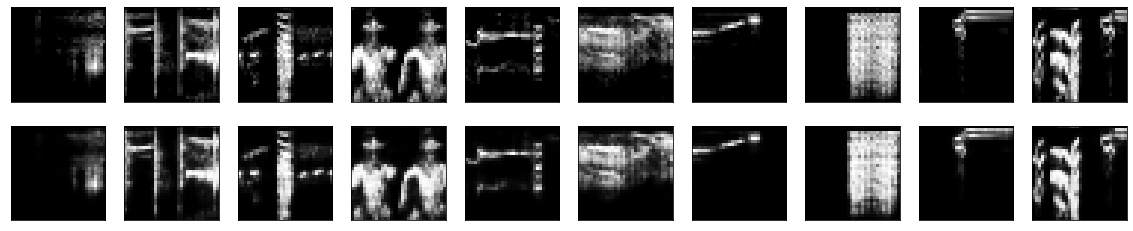

In [19]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32, 32))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [20]:
np.shape(encoded_imgs)

(5706, 1024)

In [21]:
resp_train = x_train1[:, 32:, :]
resp_test = x_val1[:, 32:, :]

In [22]:
np.save('/mnt/cube/srrudrar/ae_model/{}/32x32/stim_resp_32x32_{}/enc_test_{}.npy'.format(bird,d,d), encoded_imgs)
np.save('/mnt/cube/srrudrar/ae_model/{}/32x32/stim_resp_32x32_{}/resp_test_{}.npy'.format(bird,d,d), resp_test)